In [2]:
# This is notebook is written in Google Colab
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import os
from tensorflow.keras import layers
import glob
import imageio
import PIL
from IPython import display
from keras.layers.preprocessing.image_preprocessing import Rescaling
import time

In [ ]:
# Upload the compressed data file to colab's file folder and unzip it
!unzip '/content/emojis_am.zip' -d '/content/data'

In [4]:
# Load the training dataset
BATCH = 16
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/data',# Your path
    label_mode=None,
    image_size=(64, 64), # You can try different sizes
    batch_size=BATCH,
    shuffle=True,
).map(lambda x: x /255.)

Found 1816 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


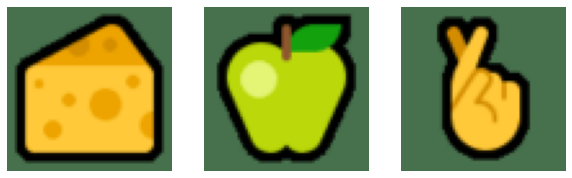

In [5]:
# Visualize our images
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
for image in train_ds.take(1):
  for i in range(3):
    axs[i].imshow((image[i]*255).numpy().astype('uint8'))
    axs[i].axis('off')

In [6]:
train_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [7]:
# Let's first build our generator
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*128, input_shape=(128,)))
    model.add(layers.Reshape((8, 8, 128)))


    model.add(layers.Conv2DTranspose(128, 3, 2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(256, 3, 2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(512, 3, 2, padding='same'))
    model.add(layers.LeakyReLU(0.2))


    model.add(layers.Conv2D(3, 5, padding='same', activation='sigmoid'))

    

    return model

In [8]:
# Have a look at details of our model
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0

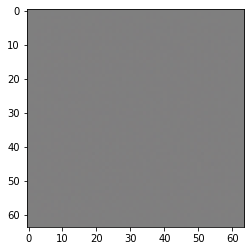

In [9]:
# Generate an image using the untrained generator with noise
noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0]*255).numpy().astype('int32'))


In [10]:
# It is time to create our discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, 3, 2, padding='same', input_shape = (64, 64, 3)))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, 2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, 2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [11]:
# Use the yet untrained discriminator to check the image just generated by our generator
discriminator = make_discriminator_model()

discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48633322]], dtype=float32)>

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [13]:
# We then define the loss functions for our generator and discriminator respectively
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):

    target = tf.concat([tf.ones_like(fake_output), tf.zeros_like(real_output)], axis=0)

    target += 0.05 * tf.random.uniform(tf.shape(target)) # Key trick

    predicted = tf.concat([fake_output, real_output], axis=0)
    
    return cross_entropy(target, predicted)

def generator_loss(fake_output):

    return cross_entropy(tf.zeros_like(fake_output), fake_output)

# Optimizers

generator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)

In [14]:
# Save checkpoints to help us restore models
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [16]:

@tf.function
def train_step(images):
    noise = tf.random.normal(shape=(BATCH, 128))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [202]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(9, 9))
  for i in range(predictions.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(((predictions[i]* 255).numpy().astype('int32')))
    plt.axis('off')

    if not epoch % 25:
      plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    seed = tf.random.normal([9, 128])
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

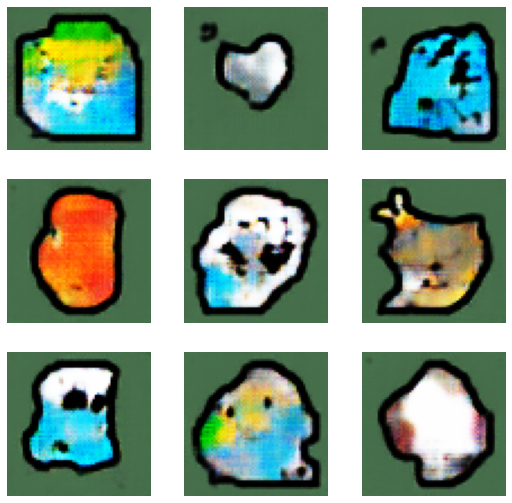

In [204]:
EPOCHS = 300
train(train_ds, EPOCHS)